Glad you joined for the exploration of the students perfomrnace dataset. This one is my first python kernel so I will be glad if you like it.
Lets dive straight in.

## Data loading and cleaning

In [43]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [19]:
#Data loading
csvFile = 'StudentsPerformance.csv'
st = pd.read_csv(csvFile)
print(st.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


The data is still not in the most clean of conditions so a bit of renaming and changes of column types are applied.

In [20]:
st = st.rename(columns = {'parental level of education' : "parentLE", 'race/ethnicity' : 'race', 'test preparation course': 'prepCourse', 'math score' : 'maths', 'reading score': 'reading', 'writing score' : 'writing'})
st['total'] = st.maths + st.reading + st.writing
st['average'] = round((st.maths + st.reading + st.writing) / 3, 1)

In [21]:
st['race'].replace(regex = True, inplace = True, to_replace = r'\group ', value = r'')
st.parentLE = st.parentLE.replace("bachelor's degree", "BSc") 
st.parentLE = st.parentLE.replace("master's degree", 'MSc')
st.parentLE = st.parentLE.replace("associate's degree", 'Associate')
st.prepCourse = st.prepCourse.replace('none', 'False')
st.prepCourse = st.prepCourse.replace('completed', 'True')

#st['race'] = st['race'].astype('category')
st['prepCourse'] = st['prepCourse'].map({'False':False, 'True':True})
#st['lunch'] = st['lunch'].astype('category')
#st['gender'] = st['gender'].astype('category')
#st['parentLE'] = st['parentLE'].astype('category')

print(st.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
gender        1000 non-null object
race          1000 non-null object
parentLE      1000 non-null object
lunch         1000 non-null object
prepCourse    1000 non-null bool
maths         1000 non-null int64
reading       1000 non-null int64
writing       1000 non-null int64
total         1000 non-null int64
average       1000 non-null float64
dtypes: bool(1), float64(1), int64(4), object(4)
memory usage: 71.4+ KB
None


## Data visualization
As the data looks better now, we cruise into the visualization part.

### Does preparation matter
Next on we explore how well did students perfomem based on whether they to a prepCourse or not.

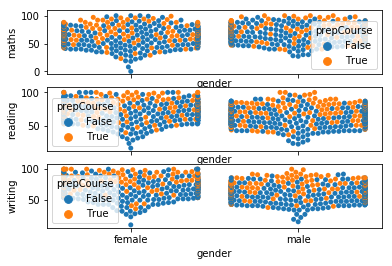

In [22]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize = (8,7))
sns.swarmplot(x="gender", y="maths",hue="prepCourse", data=st, size = 3, ax = axs[0])
sns.swarmplot(x="gender", y="reading",hue="prepCourse", data=st, size = 3, ax = axs[1])
sns.swarmplot(x="gender", y="writing",hue="prepCourse", data=st, size = 3, ax = axs[2])
plt.show()

It seems like taking a preparation course paid off well in respect to the writing and reading scores, but the results are
not so firm regarding the maths scores.

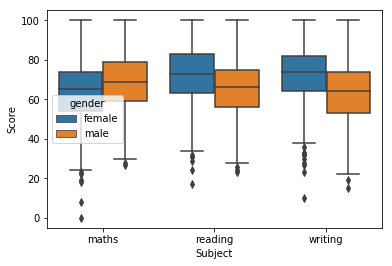

In [24]:
#gender performance across subjects
scores = st.drop(['total', 'average', 'parentLE', 'race', 'lunch'], 1)
scores = pd.melt(scores, ('gender','prepCourse'), ('maths', 'reading', 'writing'))
sns.boxplot(x = "variable", y = 'value', hue = 'gender', data = scores)
plt.xlabel('Subject')
plt.ylabel('Score')
plt.show()

On average boys perform better in maths, whereas writing and reading is reserved for girls domination.

### Reading vs writing scores

c:\users\jupiter\appdata\local\programs\python\python35\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


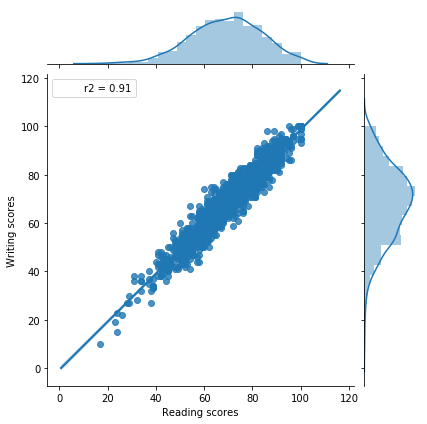

In [26]:
#reading vs writing scores
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(st.reading, st.writing, kind="reg", stat_func=r2)
plt.xlabel('Reading scores')
plt.ylabel('Writing scores')
plt.show()

Interestingly enough, we see that the correlation between the reading and writng scores seems to be fairly high.

### Math scores higher than average

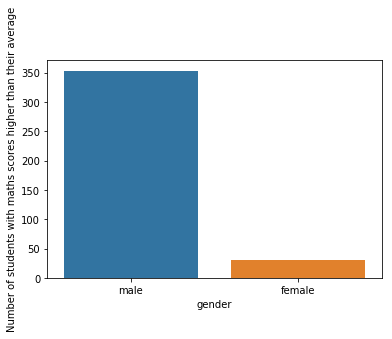

In [27]:
#Math scores higher than average
plt.clf()
maths_higher_than_average = st.gender[st.maths > st.average]
sns.countplot(maths_higher_than_average)
plt.ylabel('Number of students with maths scores higher than their average')
plt.show()

The barplot shows the number of students whose math score is higher than their average:(reading + writing + maths)/3. This result is not to say that the score of boys is that much higher, rather that if they are better in any of the three subjects most likely it is gonna be maths.

### Scores related to race/ethnicity

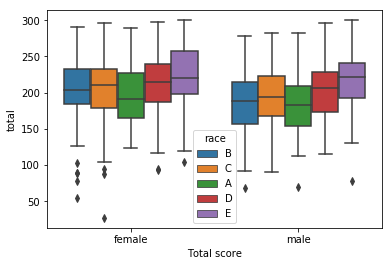

In [29]:
#scores related to race/ethnicity
sns.boxplot(x='gender', y='total', hue = 'race', data = st)
plt.xlabel('Total score')
plt.show()

Here we see that there is a certain pattern of how well students did in total, depending on their race/etnicity.

### Scores related to parents' education

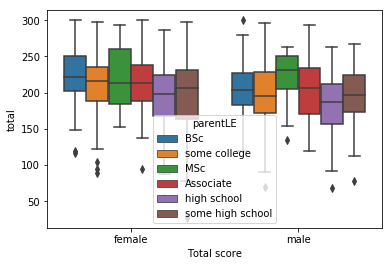

In [31]:
#scores related to parents' education
sns.boxplot(x='gender', y='total', hue = 'parentLE', data = st)
plt.xlabel('Total score')
plt.show()

For guys having a MSc parent seems to give an advantage on average, but it is not as pronounced with the girls.

### Parents divided into categories of race/etnicity and level of education

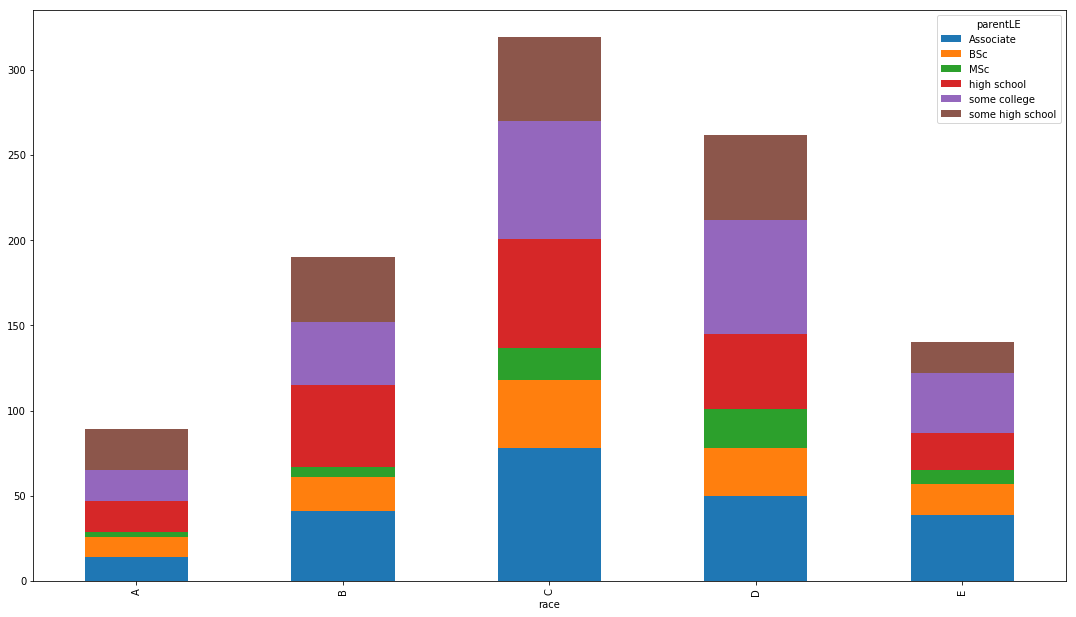

In [33]:
#This last one represents the number of students with parents divided into categories of race/etnicity and level of education
raceEdu = st[['race', 'parentLE']].groupby(['race', 'parentLE']).size().reset_index()
raceEdu.rename(columns = {0 : 'count'}, inplace = True)
raceEdu = raceEdu.pivot_table(values='count', index='race', columns='parentLE')
raceEdu.plot(kind='bar', stacked=True, figsize=(18.5, 10.5))

Even though, C seems to be the one with highest absolute number of students, the comparison to the others reveals no clear
pattern as to certain enthnic group having more people (parents) with certain education level.

## Additional cleanup in preparation for the KNN (K nearest neighbour regression classifier)

In [34]:
print(st.gender.unique())
print(st.race.unique())
print(st.parentLE.unique())
print(st.lunch.unique())
print(st.prepCourse.unique())

['female' 'male']
['B' 'C' 'A' 'D' 'E']
['BSc' 'some college' 'MSc' 'Associate' 'high school' 'some high school']
['standard' 'free/reduced']
[False  True]


In [35]:
students = st
students['gender'] = students['gender'].apply(lambda g: 1 if g == "male" else 0)
students['lunch'] = students['lunch'].apply(lambda l: 1 if l == "standard" else 0)
students['race'] = students['race'].apply(lambda r: 0 if r == "A" else 
                                                     1 if r == "B" else
                                                     2 if r == "C" else
                                                     3 if r == "D" else 4)
students['parentLE'] = students['parentLE'].apply(lambda r: 0 if r == "some high school" else 
                                                     1 if r == "high school" else
                                                     2 if r == "some college" else
                                                     3 if r == "Associate" else
                                                     4 if r == "BSc" else 5)

students['prepCourse'] = students['prepCourse'].astype('int64')
students['average'] = students['average'].astype('int64')
print(students.info())

[0 1]
[1 2 0 3 4]
[4 2 5 3 1 0]
[1 0]
[0 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
gender        1000 non-null int64
race          1000 non-null int64
parentLE      1000 non-null int64
lunch         1000 non-null int64
prepCourse    1000 non-null int64
maths         1000 non-null int64
reading       1000 non-null int64
writing       1000 non-null int64
total         1000 non-null int64
average       1000 non-null int64
dtypes: int64(10)
memory usage: 78.2 KB
None


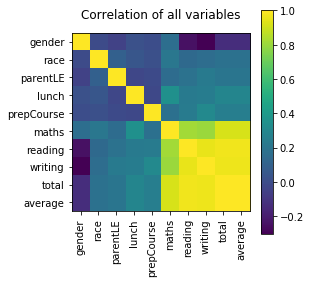

In [36]:
plt.matshow(students.corr())
plt.gca().xaxis.tick_bottom()
plt.xticks(range(len(students.columns)), students.columns)
plt.xticks(rotation = 90)
plt.yticks(range(len(students.columns)), students.columns)
plt.colorbar()
plt.title("Correlation of all variables")
plt.show()

## Preparation for regression based on KNN (K means neighbor)

In [64]:
#source - https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
def optimalK(maxK, X_train, X_test, y_train, y_test):
    from math import sqrt
    from sklearn.metrics import mean_squared_error

    rmse_val = [] #to store rmse values for different k
    for K in range(maxK):
        K = K+1
        model = KNeighborsRegressor(n_neighbors = K)

        model.fit(X_train, y_train)  #fit the model
        pred=model.predict(X_test) #make prediction on test set
        error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
        rmse_val.append(error) #store rmse values

    #plotting the rmse values against k values
    curve = pd.DataFrame(rmse_val) #elbow curve 
    curve.plot()
    
    print("Optimal k value is: %s" % (rmse_val.index(min(rmse_val)) + 1))
    print('RMSE is %s' % (min(rmse_val)))
    
    return(rmse_val.index(min(rmse_val)) + 1)

### Predicting average scores

Next on we will use the social variables in an attempt to build a model that predicts the average grade of the students.

Optimal k value is: 10
RMSE is 12.936487158421329


10

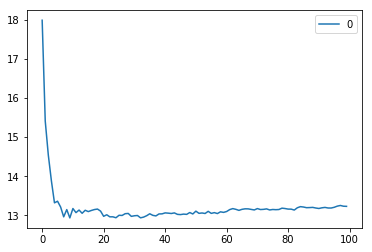

In [78]:
X_train, X_test, y_train, y_test = train_test_split(students[['race','parentLE', 'gender', 'prepCourse', 'lunch']],
                                                    students.average, test_size=0.30)

optimalK(100, X_train, X_test, y_train, y_test)

The root square standard error is relatively high pointing out that the precision of the prediction will be in the range of 13 points. The model is not precise primarily due to the fact that in this first case we only used categorical variables.

Let's try to predict the average score based only on a single grade rather than all other social factors.

Optimal k value is: 31
RMSE is 5.7169706169467895


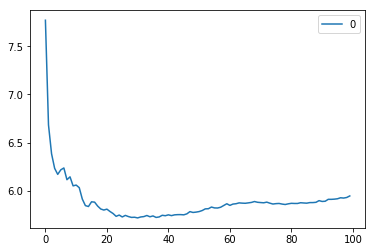

In [84]:
X_train, X_test, y_train, y_test = train_test_split(students[['writing']],
                                                    students.average, test_size=0.30)

optK_maths = optimalK(100, X_train, X_test, y_train, y_test)

It's no surprise that a single grade has much more predictive power that all the other social variables which are only categorical.

On the last figure about the average score of students we can see that when combined all social information and the writing grade compliment each other and improve the model.

Optimal k value is: 7
RMSE is 3.4864460590189803


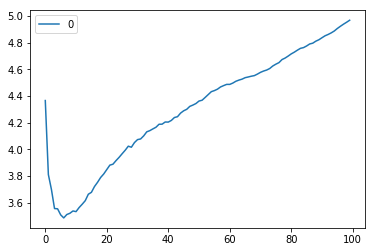

In [80]:
X_train, X_test, y_train, y_test = train_test_split(students[['race','parentLE', 'gender', 'prepCourse', 'lunch', 'writing']],
                                                    students.average, test_size=0.30)

optK_maths = optimalK(100, X_train, X_test, y_train, y_test)

### Predicting scores in reading

In addition to the 'preparation course' and 'gender' variables, for the prediction of reading I will also use the writing scores.

Optimal k value is: 10
RMSE is 4.280590443555019


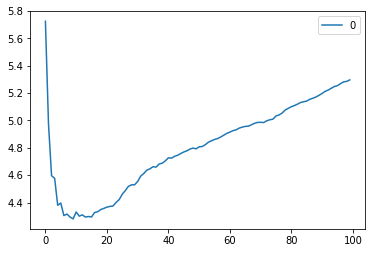

In [81]:
X_train, X_test, y_train, y_test = train_test_split(students[['gender', 'prepCourse', 'writing']],
                                                    students.reading, test_size=0.33)

optK_reading = optimalK(100, X_train, X_test, y_train, y_test)

In [82]:
knn = KNeighborsRegressor(n_neighbors=optK_reading)
knn.fit(X_train,y_train)

pred_knn = knn.predict(X_test)
print('Actual:    %s' % y_test[1:7].values)
print('Predicted: %s' % pred_knn[1:7])

Actual:    [ 74  58  56  79 100  78]
Predicted: [74.  57.4 53.6 85.7 99.5 67.3]


We could be faily precise with predicting the reading score based on writing marks having a RMSE of approx. 4.3. 



That was the end of my first python kernel. If you liked it as much as I did developing it, please upvote.